
========= 세션: Feedback =========

===== Player_sub01_Observer_sub02.mat =====

===== Player_sub03_Observer_sub06.mat =====

===== Player_sub04_Observer_sub05.mat =====

===== Player_sub05_Observer_sub04.mat =====

===== Player_sub06_Observer_sub03.mat =====

===== Player_sub07_Observer_sub08.mat =====

===== Player_sub08_Observer_sub07.mat =====

===== Player_sub09_Observer_sub10.mat =====

===== Player_sub10_Observer_sub09.mat =====

===== Player_sub11_Observer_sub12.mat =====

===== Player_sub12_Observer_sub11.mat =====

===== Player_sub13_Observer_sub14.mat =====

===== Player_sub14_Observer_sub13.mat =====

===== Player_sub15_Observer_sub16.mat =====

===== Player_sub16_Observer_sub15.mat =====

===== Player_sub17_Observer_sub18.mat =====

===== Player_sub18_Observer_sub17.mat =====

===== Player_sub19_Observer_sub22.mat =====

===== Player_sub20_Observer_sub21.mat =====

===== Player_sub21_Observer_sub20.mat =====

===== Player_sub22_Observer_sub19.mat =====

===== Player_sub23_O

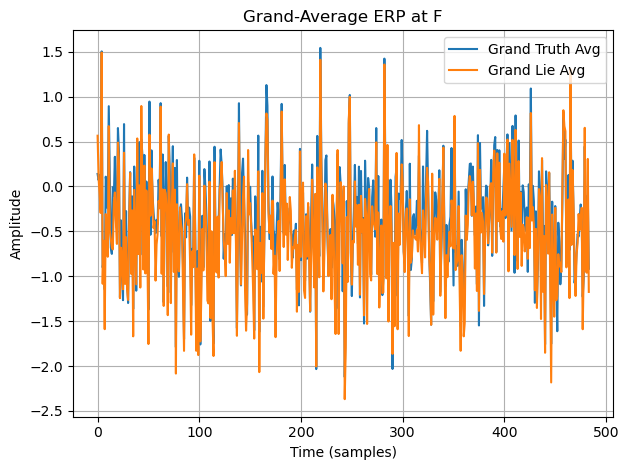


 모든 결과가 저장되었습니다!
폴더: C:\Users\pc\Downloads\ERP_results_combined


In [2]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 설정
sessions = ['Feedback', 'DecisionMaking']
base_dir = r'C:\Users\pc\Downloads\Preprocessed\Preprocessed'
output_dir = r'C:\Users\pc\Downloads\ERP_results_combined'
os.makedirs(output_dir, exist_ok=True)

participant_accuracies = []
all_mean_truth = []
all_mean_lie = []

excel_path = os.path.join(output_dir, 'ERP_All_Participants.xlsx')
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    for session in sessions:
        print(f"\n========= 세션: {session} =========")
        session_dir = os.path.join(base_dir, session)
        filenames = [f for f in os.listdir(session_dir) if f.endswith('.mat')]

        for filename in filenames:
            file_path = os.path.join(session_dir, filename)
            print(f"\n===== {filename} =====")

            try:
                data = scipy.io.loadmat(file_path)
                player_data = data['player'][0, 0]
                eeg = player_data[1]
                labels = player_data[3][0][:eeg.shape[0]]
                channels = [ch[0] for ch in player_data[2][0][0]]
                times = np.arange(eeg.shape[2])

                # truth / lie 분리 및 평균
                truth_eeg = eeg[labels == 0]
                lie_eeg = eeg[labels == 1]
                mean_truth = truth_eeg.mean(axis=0)
                mean_lie = lie_eeg.mean(axis=0)
                all_mean_truth.append(mean_truth)
                all_mean_lie.append(mean_lie)

                ch_name = 'F'
                if ch_name in channels:
                    ch_idx = channels.index(ch_name)

                    # ERP 시각화 저장
                    plt.figure()
                    plt.plot(times, mean_truth[ch_idx], label='Truth')
                    plt.plot(times, mean_lie[ch_idx], label='Lie')
                    plt.title(f"{filename} - ERP at {ch_name} ({session})")
                    plt.xlabel("Time (samples)")
                    plt.ylabel("Amplitude")
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()

                    img_name = f"ERP_{session}_{filename.replace('.mat', '')}.png"
                    plt.savefig(os.path.join(output_dir, img_name))
                    plt.close()

                    # Excel 시트로 저장 (Time + Truth + Lie)
                    erp_df = pd.DataFrame({
                        'Time': times,
                        f'{ch_name} (Truth)': mean_truth[ch_idx],
                        f'{ch_name} (Lie)': mean_lie[ch_idx]
                    })
                    sheet_name = f"{session}_{filename.replace('.mat', '')}"[:31]
                    erp_df.to_excel(writer, sheet_name=sheet_name, index=False)

                else:
                    print(f"채널 {ch_name} 없음 → 시각화 생략")

                # 분류 정확도 측정
                X = eeg.reshape(eeg.shape[0], -1)
                y = labels
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                clf = LogisticRegression(max_iter=1000)
                clf.fit(X_train, y_train)
                acc = accuracy_score(y_test, clf.predict(X_test))
                participant_accuracies.append((session, filename, acc))

            except Exception as e:
                print(f"오류 발생: {filename} → {e}")

# 평균 ERP 계산 및 저장
ref_shape = all_mean_truth[0].shape
valid_truth = [t for t in all_mean_truth if t.shape == ref_shape]
valid_lie = [l for l in all_mean_lie if l.shape == ref_shape]

if valid_truth and valid_lie:
    grand_mean_truth = np.mean(valid_truth, axis=0)
    grand_mean_lie = np.mean(valid_lie, axis=0)

    if ch_name in channels:
        ch_idx = channels.index(ch_name)
        plt.figure()
        plt.plot(times, grand_mean_truth[ch_idx], label='Grand Truth Avg')
        plt.plot(times, grand_mean_lie[ch_idx], label='Grand Lie Avg')
        plt.title(f"Grand-Average ERP at {ch_name}")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"Grand_Average_ERP_{ch_name}.png"))
        plt.show()

# 분류 정확도 저장
accuracy_df = pd.DataFrame(participant_accuracies, columns=['세션', '파일명', '정확도'])
accuracy_df.to_csv(os.path.join(output_dir, '분류정확도_결과.csv'), index=False)

print("\n 모든 결과가 저장되었습니다!")
print("폴더:", output_dir)
